## **1. Import libraries**

In [ ]:
import os
import torch
from datasets import load_dataset
from unsloth import FastVisionModel

from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
from transformers import TextStreamer

device = "cuda" if torch.cuda.is_available() else "cpu"

## **2. Load model and LoRA configuration**

In [ ]:
model_name = "unsloth/Qwen2-VL-2B-Instruct"
model, tokenizer = FastVisionModel.from_pretrained(
    model_name,
    load_in_4bit = True,
    use_gradient_checkpointing = "unsloth",
)

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers = True,
    finetune_language_layers = True,
    finetune_attention_modules = True,
    finetune_mlp_modules = True,
    r = 16,
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    random_state = 59,
    use_rslora = False,
    loftq_config = None
)

## **3. Load data**

In [ ]:
dataset_name = "5CD-AI/Viet-Receipt-VQA"
dataset = load_dataset(dataset_name, split = "train").select(range(500))

In [ ]:
dataset

Dataset({
    features: ['id', 'image', 'description', 'extractions', 'conversations'],
    num_rows: 500
})

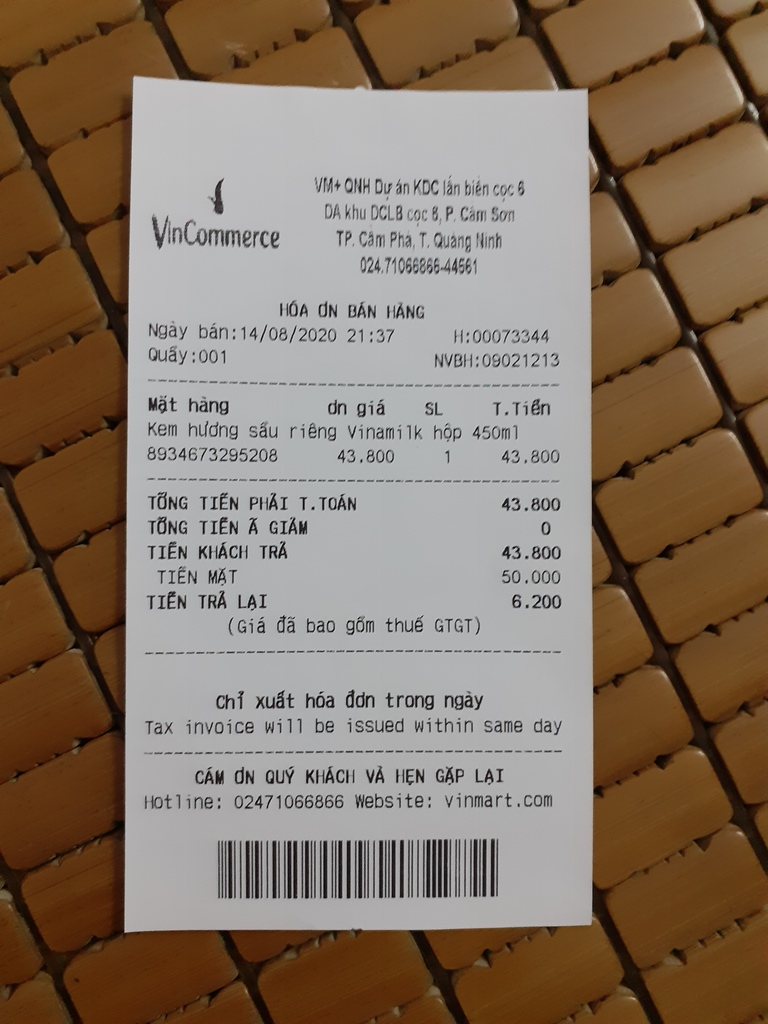

In [ ]:
dataset[0]["image"]

In [ ]:
dataset[0]["description"]

'Hóa đơn bán hàng của Vincommerce, ngày 14/08/2020, 21:37, mã hóa đơn H:00073344, NVBH:09021213,  gồm 1 mặt hàng là Kem hướng sữa  riêng Vinamilk hộp 450ml với đơn giá 43.800, tổng tiền phải trả 43.800, tiền khách trả 50.000, tiền trả lại 6.200.'

In [ ]:
instruction = "Tổng hợp và mô tả nội dung của hóa đơn trong ảnh thành một đoạn văn"

def convert_to_conversation(sample):

    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["description"]} ]
        },
    ]

    return { "messages" : conversation }

In [ ]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

In [ ]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Tổng hợp và mô tả nội dung của hóa đơn trong ảnh thành một đoạn văn'},
    {'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=768x1024>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'Hóa đơn bán hàng của Vincommerce, ngày 14/08/2020, 21:37, mã hóa đơn H:00073344, NVBH:09021213,  gồm 1 mặt hàng là Kem hướng sữa  riêng Vinamilk hộp 450ml với đơn giá 43.800, tổng tiền phải trả 43.800, tiền khách trả 50.000, tiền trả lại 6.200.'}]}]}

In [ ]:
def prepare_chat_inputs(image, instruction, tokenizer,
                        device="cuda", add_generation_prompt=True):
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": instruction}
            ]
        }
    ]


    input_text = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=add_generation_prompt
    )

    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt"
    ).to(device)

    return inputs


def run_inference(model, inputs, tokenizer,
                  max_new_tokens=128, temperature=1.5, min_p=0.1):
    FastVisionModel.for_inference(model)

    text_streamer = TextStreamer(tokenizer, skip_prompt=True)

    output_text = model.generate(
        **inputs,
        streamer=text_streamer,
        max_new_tokens=max_new_tokens,
        use_cache=True,
        temperature=temperature,
        min_p=min_p
    )

    return output_text


In [ ]:
idx = 250
image = dataset[idx]["image"]
instruction = "Tổng hợp và mô tả nội dung của hóa đơn trong ảnh thành một đoạn văn"

inputs = prepare_chat_inputs(
    image=image,
    instruction=instruction,
    tokenizer=tokenizer,
    device=device
)

output_text = run_inference(
    model=model,
    inputs=inputs,
    tokenizer=tokenizer,
    max_new_tokens=128,
    temperature=1.5,
    min_p=0.1
)

Hóa đơn được in trên một tờ giấy trắng. Nội dung hóa đơn bao gồm:

- Tên khách hàng: Phố Mô
- Địa chỉ: Số 7 khu Tân Lập 4, P. Cẩm Thụy, Tp. Cẩm Phả, Quảng Ninh
- Số điện thoại: 0858.931.931
- Ngày và thời gian: 13/08/2020 - 21:55
- Khách hàng: SDT
- Địa chỉ: 

- Sản phẩm và số lượng:



In [ ]:
dataset[250]["description"]

'Hóa đơn bán hàng của quán Phở Mỡ, số hóa đơn HD130820-0040, ngày 13/08/2020, gồm 3 món: Hướng dương ốc chó, Trà chanh nha đam, Trà quất lắc sữa với tổng cộng 57.000 đồng.'

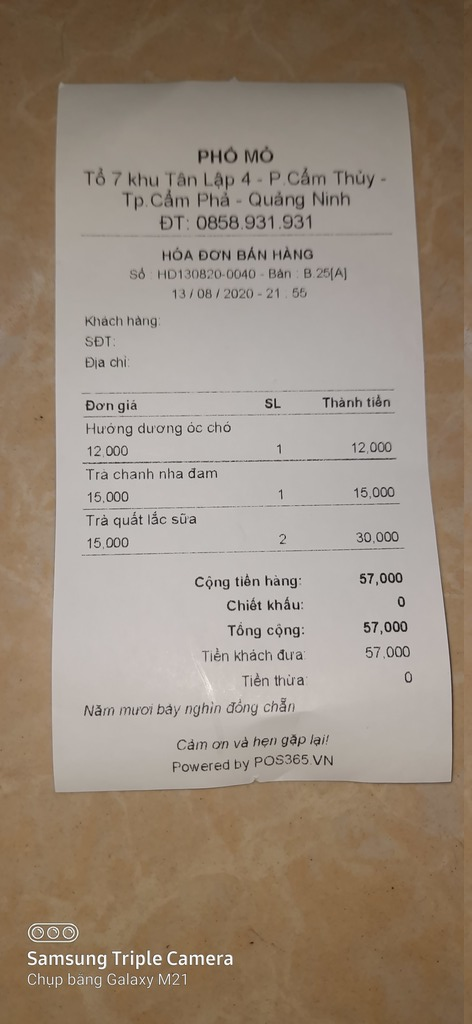

In [ ]:
image

## **4. Training**

In [ ]:
training_args = SFTConfig(
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 2,
    warmup_steps = 5,
    max_steps = 200,
    # num_train_epochs = 1,
    learning_rate = 2e-4,
    fp16 = not is_bf16_supported(),
    bf16 = is_bf16_supported(),
    logging_steps = 1,
    optim = "adamw_8bit",
    weight_decay = 0.01,
    lr_scheduler_type = "linear",
    seed = 59,
    output_dir = "outputs",
    report_to = "none",
    remove_unused_columns = False,
    dataset_text_field = "",
    dataset_kwargs = {"skip_prepare_dataset": True},
    dataset_num_proc = 4,
    max_seq_length = 2048,
)

In [ ]:
FastVisionModel.for_training(model)

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = converted_dataset,
    args = training_args
)

Unsloth: Model does not have a default image size - using 512


In [ ]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA RTX A5000. Max memory = 23.672 GB.
2.84 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 500 | Num Epochs = 1 | Total steps = 200
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 2 x 1) = 2
 "-____-"     Trainable parameters = 28,950,528/2,000,000,000 (1.45% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.619600
2,1.969200
3,1.675400
4,1.923800
5,1.321900
6,1.166800
7,0.927700
8,1.359000
9,1.143400
10,0.845000


In [ ]:
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

## **5. Inference**

In [ ]:
image = dataset[100]["image"]
instruction = "Tổng hợp và mô tả nội dung của hóa đơn trong ảnh thành một đoạn văn"

inputs = prepare_chat_inputs(
    image=image,
    instruction=instruction,
    tokenizer=tokenizer,
    device=device
)

output_text = run_inference(
    model=model,
    inputs=inputs,
    tokenizer=tokenizer,
    max_new_tokens=1024,
    temperature=1.0,
    min_p=0.1
)

Hoá đơn bán hàng của Minimart Anan, Chợ Sủi Phú Thị Gia Lâm với 2 mặt hàng: 8934868149064 nrc sunlight mêm điều chài 7 N0 và 291028000000 sáp thom glade NT. Tổng cộng 114.000 VND, khách trả 200.000 VND, tiền trả lại 86.000 VND. Số GD: 000AC2212008002095, ngày 15/08/2020-17:17, thu ngân: BH3.<|im_end|>


##  **6. Save model**

In [ ]:
model.save_pretrained("qwen2vl_1b_viet_receipt_summarization_lora_model")
tokenizer.save_pretrained("qwen2vl_1b_viet_receipt_summarization_lora_model")

[]

## **7. Use trained model for inference**

In [ ]:
model, tokenizer = FastVisionModel.from_pretrained(
    model_name = "qwen2vl_1b_viet_receipt_summarization_lora_model",
    load_in_4bit = True,
)

In [ ]:
image = dataset[100]["image"]
instruction = "Tổng hợp và mô tả nội dung của hóa đơn trong ảnh thành một đoạn văn"

inputs = prepare_chat_inputs(
    image=image,
    instruction=instruction,
    tokenizer=tokenizer,
    device=device
)

output_text = run_inference(
    model=model,
    inputs=inputs,
    tokenizer=tokenizer,
    max_new_tokens=1024,
    temperature=1.0,
    min_p=0.1
)

Hóa đơn bán hàng của Minimart Anan, Chợ Sushi Phú Thọ Gia Lâm, được in tại số điện thoại 

8934868149064. Sản phẩm được mua là 1 chai cá và 2 hộp sáp thơm glade NT. Sản phẩm được tính giá là 26,000 đồng và 44,000 đồng, tổng cộng là 114,000 đồng. Tính khâu trả là 200,000 đồng và tính trả lại là 86,000 đồng.<|im_end|>


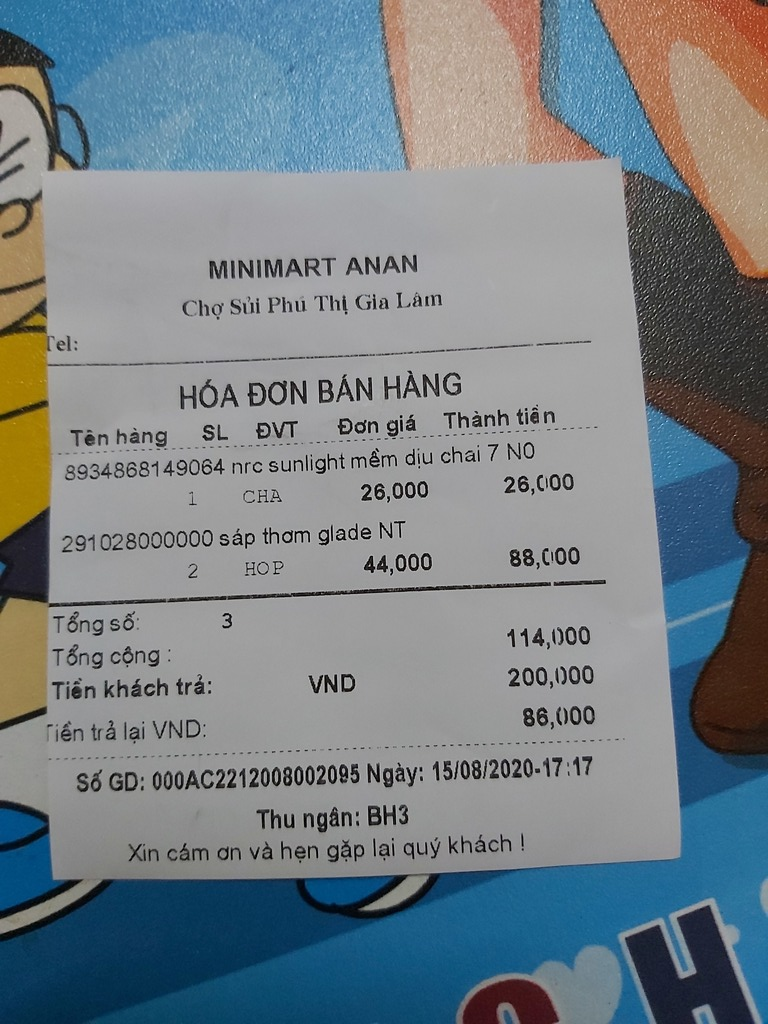

In [ ]:
image = dataset[100]["image"]
image